<img src="./img/HWNI_logo.svg"/>

# Tutorial - ANOVA by Hand

In [1]:
# makes our plots show up inside Jupyter
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import util.utils as utils
import util.shared as shared

shared.format_plots()
shared.format_dataframes()

In this tutorial, we will learn about the
[ANalysis Of VAriance](https://en.wikipedia.org/wiki/Analysis_of_variance)
model by walking through a by-hand implementation of it
in its simplest form:
the One-Way ANOVA.

In all of its forms,
ANOVA works by "partitioning" the variance in an observation
into different components.
According to our null hypothesis,
most partitions of the data don't reduce the variance very much,
so if,
once we've partitioned data according to the factors we're interested in,
the variance is greatly decreased,
then something unlikely has occurred under our null hypothesis
and we may have found an effect.

Below, we make these statements rigorous on a toy dataset
and then apply a One-Way ANOVA to a real neuroscience dataset.

# Introducing Analysis of Variance

Following Wikipedia's
[motivating example](https://en.wikipedia.org/wiki/Analysis_of_variance#Motivating_example),
we consider what might happen if we were to gather some data
about a collection of dogs.

This collection of dogs has two breeds,
each of which comes in a long-haired and a short-haired variety.
We measure the weight of each dog,
taking care to note its breed and hair length,
and organize that information into a dataframe.

In [2]:
N = 75

dogs = utils.produce_dog_dataframe(N, weight_effect = 6)
dogs.sample(5)

,breed,weight,hair_length
138,1,16.629892,1
62,0,8.744187,1
1,0,12.558978,0
25,0,10.906666,1
132,1,16.847433,0


As always,
we begin by visualizing our data.
Here, we choose a histogram.
We also calculate a summary statistic --
since we'll need it later,
we look at the variance.

In [3]:
def plot_data(dataframe, observation_name):
    data = dataframe[observation_name]
    sns.distplot(dataframe[observation_name], color = "gray")
    plt.xlim(5, 20);
    plot_mean(data, "all observations")
    plt.legend(loc=(1,0.8))
    plt.tight_layout()
    print_mean_square(data, "all observations")
    
def plot_mean(data, name, color = "gray"):
    mean = np.mean(data)
    
    ylim = plt.ylim()
    plt.vlines(mean,*ylim,
              colors=color, linestyle='--', linewidth=4,
              label = 'mean for \n' + name )

def print_mean_square(array, name):
    print("For "+ name + ", mean squared difference is {:.2f}".format(np.var(array)))

def plot_partition(dataframe, group_name, observation_name):
    
    group_values = dataframe[group_name]
    group_indices = group_values.unique()
    
    observations = dataframe[observation_name]
    
    colors = ["denim blue", "medium green"]
    
    name_string = ' '.join(word.capitalize() for word in group_name.split("_"))

    print_mean_square(dataframe[observation_name], "all data")
    
    group_means = []
    
    for group_idx in group_indices:
        partitioned_observations = observations[group_values == group_idx]
        
        group_means.append(np.mean(partitioned_observations))

        sns.distplot(partitioned_observations, label = name_string + " " + str(group_idx),
                    color = sns.xkcd_rgb[colors[group_idx]])
        print_mean_square(partitioned_observations, name_string + " " + str(group_idx))

    print_mean_square(group_means, "group means")
        
    plot_mean(observations, "all observations")
        
    for group_idx in group_indices:
        partitioned_observations = observations[group_values == group_idx]
        plot_mean(partitioned_observations, name_string + " " + str(group_idx),
                  color = sns.xkcd_rgb[colors[group_idx]])
        
    plt.xlim(5, 20)
    plt.title("Data Partitioned According to " + name_string)
    plt.legend(loc=(1,0.8))
    plt.tight_layout()

For all observations, mean squared difference is 9.64


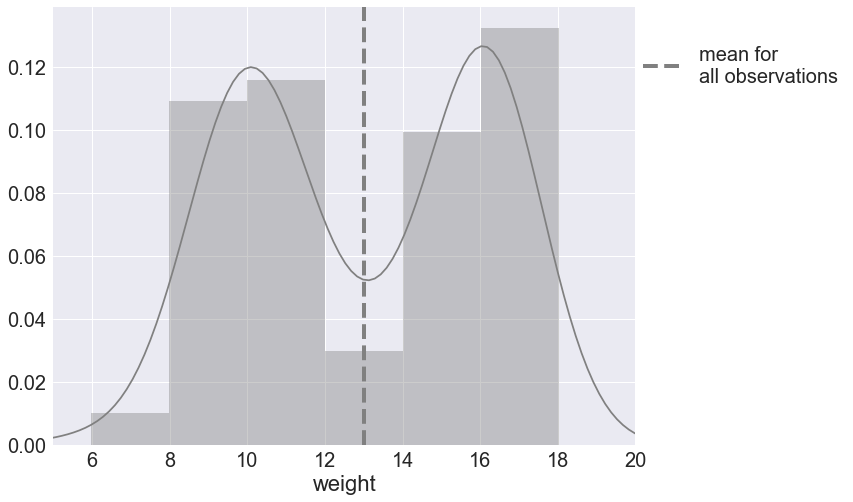

In [4]:
plot_data(dogs, "weight")

It appears that,
as far as weight is concerned,
there are only two kinds of dogs,
not four:
the histogram has two "clusters"
and the kernel density estimate has two peaks.

Intuitively,
we might guess that breed is more likely
to have a large effect on weight
than is hair length.

To determine whether this is the case,
we split our data up,
first by breed and then by hair length,
and make the same plots as before.

For all data, mean squared difference is 9.64
For Breed 0, mean squared difference is 1.40
For Breed 1, mean squared difference is 1.05
For group means, mean squared difference is 8.42


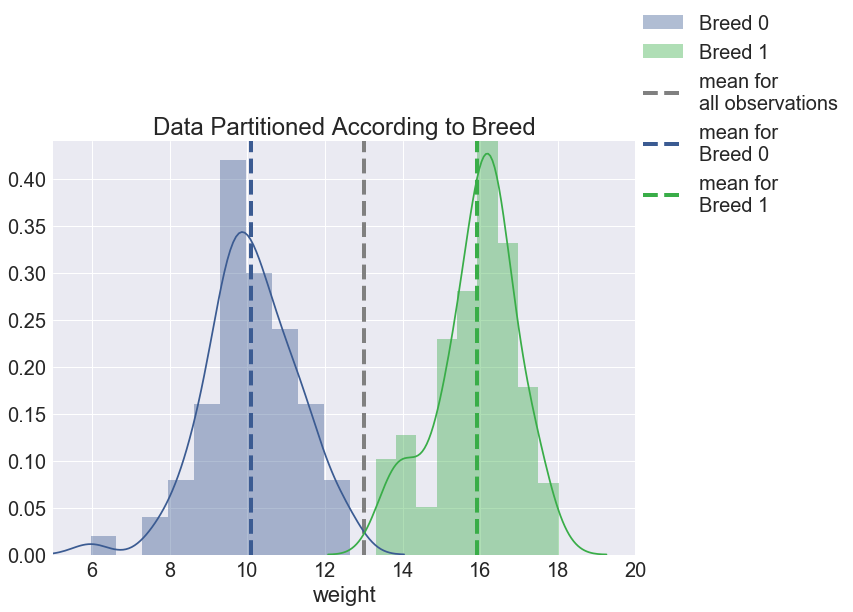

In [5]:
plot_partition(dogs, "breed", "weight" )

For all data, mean squared difference is 9.64
For Hair Length 0, mean squared difference is 9.05
For Hair Length 1, mean squared difference is 10.12
For group means, mean squared difference is 0.06


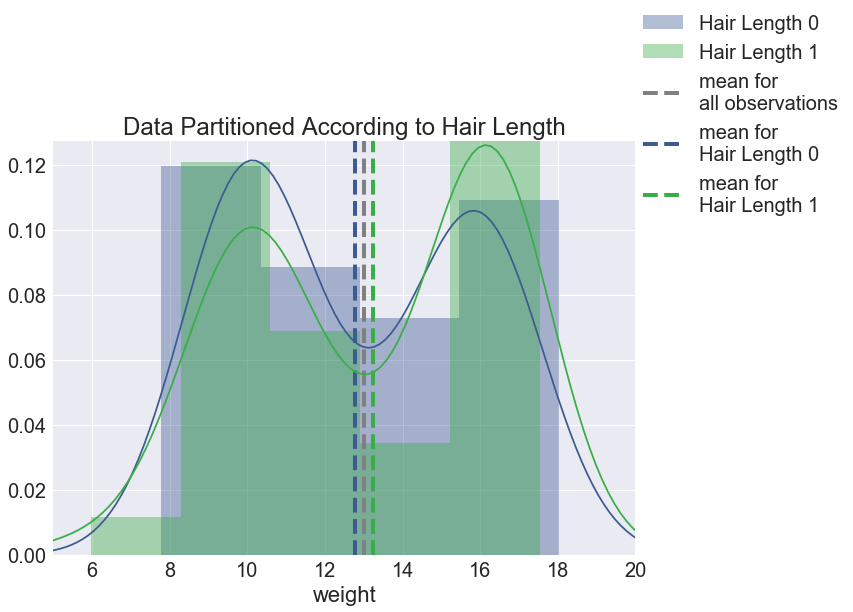

In [6]:
plot_partition(dogs, "hair_length", "weight" )

Color indicates from which group
the data in the plot was drawn.

Notice how much less
"spread out"
the data in the groups based on breed is
than the data in groups based on hair length is?
Notice also how much further apart the means
of the two breeds are,
and how much further they are from the
mean of the weights of all of the dogs?

We can quantify this "spread",
as usual, using the variance,
or the mean squared difference
from the mean.

Though the exact values are random,
we in general see that the variance in the groups based on breed
is substantially smaller than the original variance,
while the variance in the groups based on hair length
is around the same size.
Additionally,
we see that the mean squared difference of the group means
from *their* mean, which is the mean weight of all dogs,
is much larger when we group by breed than when we group by hair length.

You can also vary how much of an effect the breed has on weight
by changing the value of the `weight_effect`
argument to `produce_dog_dataframe`.
Try some different effect sizes
and see if you can predict the changes in spread.

This is the idea at the core of ANOVA:
if group membership has a strong effect on an observed variable,
then splitting the data up by group should reduce the variance substantially,
while the mean squared difference of the groups should go up.
Below, we get more specific on in which cases
this "should" be true.
We define "substantially" as
"more than when splitting the data up by a labeling unrelated to the observation".
For the data above, our unrelated labeling was the hair length.
We can, however, also create random labels and use those.

We firm up this intuition with the section below on the
data model underlying ANOVA.

## The Implicit Model in ANOVA

When we use a one-way ANOVA to model our data,
we are implicitly choosing to model the dependent variable
as the sum of three things:
1. the **grand mean**,
or the average value of all observations,
1. the **group effect**, or the change in the average value due to being in that group,
which is the difference between that grand mean and the average of observations in a particular group,
1. and the sum of any **unknown effects**,
or changes to the observed variable due to things we didn't measure,
which is just the difference between the sum of the first two terms and the value that was observed.

Below, we take this English-language description and convert it into math.

$$\begin{align}
    &\text{Observation}\ j\ \text{in Group}\ i\ &= \ &\text{Grand Mean}\ &+\ &\text{Group Effect}_i\ &+ \ &\text{Unknown Effects}_{ij} \\
    &Y_{ij} &= \ &\mu_\text{grand} \ &+\ &A_i\ &+ \ &\epsilon_{ij}
\end{align}$$

where the variable $A$ is the independent variable, the index $i$ indicates which group or level of this variable the individual was in and the index $j$ tells us which individual within the group they were.

In our dog example, $A$ would be either "hair length" or "breed" and $i$ would be the index, $0$ or $1$, for the groups within those variables. $j$ would index dogs within a group. To pick out a particular dog, we need both which group it's in, $i$, and which dog in that group it is, $j$.

This notation may seem like over-kill, but it will be necessary for more complicated ANOVAs.

## The ANOVA Statistical Test

As established above,
we'd like to break our data into groups and then calculate
the variance in each group.
We'd like this to be small
and we'd like the differences between groups to be large.

The appropriate statistic is a ratio of the variance of the group effects
to the variance of the unknown effects.
This statistic is called the
$F$-statistic,
named in honor of its inventor,
[Sir Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher).

Large values of $F$ are unlikely under the null hypothesis
that the true size of the group effect is $0$.

To make this model tractable,
we have to assume something about these "unknown effects".
Into this category we lump everything that we did not measure,
everything that does not correspond to a group in our study,
but which can conceivably impact the observed value.
Appealing to the
[Central Limit Theorem](https://www.khanacademy.org/math/statistics-probability/sampling-distributions-library/sample-means/v/central-limit-theorem),
we say that the things we aren't measuring are
independent from each other and our groups,
large in number,
and individually have small effects on our observed variable,
and therefore the distribution of their impacts on the observed variable
is a Gaussian.

## When to Use ANOVA

The discussion above,
full of comparisons of means to baselines
and calculations of variances as yardsticks
reminds us of the $t$-test.

And indeed, the $t$-test is a particularly simple One-Way ANOVA,
with only two groups.
Running the $t$-test on our dog-breeds data
would give the same result as running an ANOVA.

One might then imagine that we don't need an ANOVA:
we simply use the $t$-test for data from each group
versus the rest of the data.

However, this requires us to perform multiple hypothesis tests.
Each time we perform a hypothesis test,
there is a chance of a false positive.

The utility of ANOVA comes from the fact that it lets us test
the hypothesis that the mean of at least one
of the levels of the variable we are using
to group our observations
is different from the overall mean
without specifying which level it is.

Once we've verified that this over-all null hypothesis is true,
we can more confidently perform additional $t$-tests
to narrow down just what exactly our data tells us.
Though diminished,
there are still concerns about multiple comparisons,
which we will cover in more depth
in the second ANOVA section.

## When Not to Use ANOVA

Our assumption about the distribution of the unobserved effects is frequently incorrect:
for example,
whether the participant is hungover or not
can have a very strong impact on their performance and
it is not independent of the age variable.
When we have rare effects that cause big changes in the observed value,
the result is *outliers*.
ANOVA is not robust to violations of the assumption
that there are no outliers,
but we won't be discussing alternatives in this course.

We also assume that the expected magnitude of the unknown effects
is the same for each group --
that the variance of the unknown effects
doesn't depend on the group.
The Greek term for "spread" is
*skedasis*, so if we assume that the spread,
or variance,
is the same across groups, we are assuming
*homoscedasticity*,
as opposed to
*heteroscedasticity*.
If your groups are all the same size,
then ANOVA is actually quite robust
to violations of this assumption.
See
[this discussion on CrossValidated](https://stats.stackexchange.com/questions/97098/practically-speaking-how-do-people-handle-anova-when-the-data-doesnt-quite-mee)
for more.

Define familywise error rate here?

# Implementing ANOVA

## Example Dataset

For the rest of this section's tutorial and lab, we'll be using some EEG data graciously provided by the [Voytek lab](http://voyteklab.com/about-us/) of UCSD. Participants of varying ages were asked to perform a working memory task with varying levels of difficulty. The raw EEG signal has been summarized into the following two measures:

* [Contralateral Delay Activity](https://www.ncbi.nlm.nih.gov/pubmed/26802451), or CDA, is used to measure the engagement of visual working memory.

* [Frontal Midline Theta](https://www.ncbi.nlm.nih.gov/pubmed/9895201) oscillation amplitude has been correlated with sustained, internally-directed cognitive activity.

The performance of the subjects has also been summarized using the measure
[d'](https://en.wikipedia.org/wiki/Sensitivity_index) (pronounced "d-prime"), also known as the *sensitivity index*. D' is a measure of the subject's performance in  a task. It's based on comparing the true positive rate and false positive rate.

## Loading the Data

In [7]:
df = pd.read_csv('./data/voytek_working_memory_aging_split.csv',index_col=None)

df.sample(5)

,idx,id,age_split,group,age,difficulty,d,cda,fmt
44,20,21,3,2,55,2,4.25,1.73,-0.34
29,5,6,2,1,25,2,4.18,2.12,-0.35
45,21,22,3,2,58,2,4.34,0.93,0.25
43,19,20,3,2,58,2,2.88,1.87,-1.79
10,10,11,1,1,19,1,4.62,1.89,0.61


For the purposes of this lab, we're interested only in how task difficulty affects our three measures. We're uninterested in the subject's metadata -- `age_split`, `group`, `age`, and `idx`. Let's begin by dropping those columns from our dataframe using the DataFrame method `drop`.

In [8]:
data = df.drop(['age_split','group','age','idx'], axis=1)
data.sample(5)

,id,difficulty,d,cda,fmt
35,12,2,3.91,0.44,-0.51
56,9,3,3.26,3.12,0.66
43,20,2,2.88,1.87,-1.79
6,7,1,4.23,1.50,0.90
46,23,2,3.27,1.87,0.89


It's good practice to keep an original copy of your dataframe around (here, named `df`) so you can undo irreversible changes, like dropping columns.

## ANOVA by Hand

To get a better understanding of ANOVA,
we'll now implement it from scratch.

To get started,
you'll need the total number of observations $N$,
the group sizes
(here, each group is the same size),
and the keys for each group
(here, 1, 2, and 3, and they're the `unique` values of the `difficulty` variable).

The first cell picks a measure to run ANOVA on.
We'll want to write all of our code that follows in such a way
that we can run ANOVA on the other measures
just by changing this one cell.

In [9]:
measure = "cda"

In [10]:
N = len(data[measure])

groups = data["difficulty"].unique()

In [11]:
groups

array([1, 2, 3])

We'll proceed by generating a new data frame
that contains all the information we need to perform an ANOVA
-- each row will contain the grand mean and the group mean,
the group effect,
and the residual for that observation.
We will call this our `anova_frame`.

We also drop the other measures from this frame, to keep down on clutter.

In [12]:
anova_frame = data.copy().drop([unused_measure for unused_measure in ["cda", "d", "fmt"]
                                if measure != unused_measure], axis=1)

### Computing the Grand and Group Means

The cell below computes the grand mean
and the group mean for each difficulty level
and stores them in the `anova_frame`.

The precise defintions of the grand and group means appear below.

$$\begin{align}
\mu_\text{grand} &= \frac{1}{N}\sum_\text{dataset} Y_{ij} \\
\mu_{\text{group}_i} &= \frac{1}{N_{\text{group}_i}}\sum_{\text{group}_i} Y_{ij}
\end{align}$$

Note that $\mu_{\text{group}_i}$, the group *mean*, is not the same as $A_i$, the group *effect*!

The group effect is the difference between the group mean and the grand mean. We must compute the group and grand mean first, before we can compute the group effect.

In [13]:
anova_frame["grand_mean"] = anova_frame[measure].mean()

group_means = anova_frame.groupby("difficulty")[measure].mean()

for group in groups:
    anova_frame.loc[anova_frame.difficulty==group,"group_mean"] = group_means[group]

### Aside on Degrees of Freedom

Let's take a look at the resulting data frame.

In [14]:
anova_frame.sample(10)

,id,difficulty,cda,grand_mean,group_mean
65,18,3,1.55,1.474444,1.836250
34,11,2,2.09,1.474444,1.484167
48,1,3,1.81,1.474444,1.836250
5,6,1,0.84,1.474444,1.102917
11,12,1,0.15,1.474444,1.102917
25,2,2,0.73,1.474444,1.484167
14,15,1,1.36,1.474444,1.102917
47,24,2,1.00,1.474444,1.484167
45,22,2,0.93,1.474444,1.484167
69,22,3,1.20,1.474444,1.836250


There are only three unique values in the `group_mean` column, corresponding to the three group means. If we calculate their average value, we'll find that it is equal to the grand mean.

In [15]:
group_means = anova_frame["group_mean"].unique()

print(group_means)

np.mean(group_means) - anova_frame[measure].mean() < 1e-4

[ 1.10291667  1.48416667  1.83625   ]


True

This value is equal to the grand mean.
If we know the grand mean,
we only need two of the group means to know the other.

Put another way, though we have three numbers here in the form of our three group means,
the value of the third is constrained by the values of the other two (and the grand mean).
There are only two "free parameters" here,
rather than three.
The number of free parameters is also known as the number of
*degrees of freedom*,
terminology that is borrowed from physics.

When we are computing inferential statistics,
we need to use the number of degrees of freedom,
rather than the total number of observations.

For the mean, this doesn't cause an issue,
because the mean is computed independently
from all of the datapoints.

However, the variance is computed
using the value of the mean,
which is calculated from the same data.
Therefore if we know the mean, the variance,
and all but one of the data values,
then we can calculate the missing value.
Therefore the variance has one less degree of freedom,
so the proper formula for the variance
as an inferential statistic of the data is

$$ \frac{1}{N-1} \sum_\text{dataset} \left(\text{observation}\ -\ \text{average of observations} \right)^2 $$

This will become important later when we calculate the variances.

### Computing the Group and Unknown Effects

Now, we compute the explained and unexplained, or residual, components for each observation.
The explained differences are the differences between the group average and the overall average.
The unexplained difference is the difference between the individual score and the group average.

Above, these were called the "group effect" and the "unknown effect", respectively.
Terminology differs between authors.
Different terms correspond to different particular intuitions about ANOVA,
and we should be familiar with all of them.

$$\begin{align}
\text{Group Effect}_i &= \text{Explained Component}_i \\
            &= \mu_{\text{group}_i} - \mu_\text{grand}  \\
            \\
\text{Unknown Effects}_{ij} &= \text{Unexplained Component}_{ij} = \text{Residual}_{ij} \\
            &= Y_{ij} - \left(\text{Grand Mean}\ +\ \text{Group Effect}_i \right) \\
            &= Y_{ij} - \mu_{\text{group}_i}
\end{align}$$

In [16]:
anova_frame["explained"] = anova_frame["group_mean"]-anova_frame["grand_mean"]

anova_frame["residual"] = anova_frame[measure]-anova_frame["group_mean"]

In [17]:
anova_frame.sample(10)

,id,difficulty,cda,grand_mean,group_mean,explained,residual
60,13,3,0.55,1.474444,1.836250,0.361806,-1.286250
0,1,1,1.00,1.474444,1.102917,-0.371528,-0.102917
11,12,1,0.15,1.474444,1.102917,-0.371528,-0.952917
24,1,2,2.04,1.474444,1.484167,0.009722,0.555833
19,20,1,0.65,1.474444,1.102917,-0.371528,-0.452917
5,6,1,0.84,1.474444,1.102917,-0.371528,-0.262917
41,18,2,0.75,1.474444,1.484167,0.009722,-0.734167
21,22,1,-0.32,1.474444,1.102917,-0.371528,-1.422917
2,3,1,0.84,1.474444,1.102917,-0.371528,-0.262917
14,15,1,1.36,1.474444,1.102917,-0.371528,0.257083


To check our work, we confirm that the total value for each observation is equal to the sum of the grand mean, the explained component, and the residual.

In [18]:
np.isclose(anova_frame[measure], anova_frame["grand_mean"] 
                                + anova_frame["explained"]
                                  + anova_frame["residual"]).all()

True

This is a condition that is guaranteed by our model,
which states that any component of our observation that isn't explainable
as a deviation in group mean from the grand mean
is due to an unknown effect and is
to be left unexplained, or residual.

Review the implicit ANOVA model below and compare it to the `anova_frame` above.
Where is each component in this dataframe? How are they related to each other?

$$\begin{align}
    &\text{Observation}\ j\ \text{in Group}\ i\ &= \ &\text{Grand Mean}\ &+\ &\text{Group Effect}_i\ &+ \ &\text{Unknown Effects}_{ij} \\
    &Y_{ij} &= \ &\mu_\text{grand} \ &+\ &A_i\ &+ \ &\epsilon_{ij}
\end{align}$$

### Computing Sums of Squares

Now that we have all of our components,
we need to compute their mean squares.
The general formula for computing the mean squared difference from the mean is

$$
\text{Variance of Observed Variable} = \frac{1}{\text{degrees of freedom}} \sum_\text{observations} \left(\text{observation}\ -\ \text{average of observations}\right)^2
$$

where everything except the inverse degrees of freedom
is called a
*sum of squares*,
for the obvious reason.

As a first step to calculating each mean square,
we calculate several sums of squares.

Using the symbol $SS$ to stand for "sum of squares",
we define the following:

$$\begin{align}
SS_\text{Total} &= \sum_\text{dataset} Y_{ij}^2 \\
SS_\text{Grand Mean} &= \sum_\text{dataset} \mu_\text{grand}^2 \\
SS_\text{Explainable} = SS_\text{Total} - SS_\text{Grand Mean} 
                     &= \sum_\text{dataset} \left(Y_{ij} - \mu_\text{grand}\right)^2 \\
SS_{\text{Explained}} = \sum_\text{groups} SS_{\text{Group Effect}_i}
                     &= \sum_\text{groups} \sum_{\text{group}_i} A_i^2 \\
SS_{\text{Residual}} = SS_\text{Explainable} - SS_\text{Explained}
                     &= \sum_\text{dataset} \left(Y_{ij} - A_i - \mu_{grand}\right)^2
\end{align}$$

also known as the total sum of squares, sum of the grand mean squared,
the sum of squares that can be explained by a model,
the sum of squares that were explained by the model,
and the residual sum of squares.

Several of the equations above, like the one relating
the explainable sum of squares to the total and grand mean sums of squares,
can be used to determine whether we've done our calculations correctly.
The assertion statements in the code cell under the next check this.

We'll store the sums of squares in a dictionary, `sum_of_squares`, using the column name as the key.

In [19]:
sum_of_squares = {}

keys = [measure,"grand_mean","explained","residual"]

for key in keys:
    sum_of_squares[key] = np.sum(np.square((anova_frame[key])))
    
sum_of_squares["explainable"] = sum_of_squares[measure] - sum_of_squares["grand_mean"]

In [20]:
# these should be the same, except for computer rounding error

assert( sum_of_squares[measure] - (sum_of_squares["grand_mean"] + 
                                 sum_of_squares["explainable"]) <= 1e-4 )

assert( sum_of_squares["explainable"] - (sum_of_squares["explained"] +
                                       sum_of_squares["residual"]) <= 1e-4 )

In [21]:
sum_of_squares

{'cda': 204.53820000000002,
 'explainable': 48.011177777777817,
 'explained': 6.4567361111111206,
 'grand_mean': 156.5270222222222,
 'residual': 41.554441666666669}

### Computing Mean Squares

If we use an alternative formula for variance:

$$\begin{align}
\text{Variance}(X) = \frac{1}{\text{degrees of freedom}} \left( SS(X) - SS(\mu_X) \right)
\end{align}$$

where $\mu_X$ is the mean of $X$,
we see that our explained sum of squares, 
$$
\ \\
SS_\text{Explained} = SS_\text{Group Means} - SS_\text{Grand Mean}\\
$$
is ready to be turned into a variance:
the average of the group means is the grand mean,
so dividing the explained sum of squares
by its degrees of freedom tells us
the variance of our predictions,
aka the spread of the group means.

In addition, the mean of the residuals is by definition $0$,
so the mean squared difference of the residuals from their mean is just
$$
\ \\ 
\frac{1}{\text{degrees of freedom}}SS_{\text{Residual}} \\
$$
and so we also only need to divide by degrees of freedom to get the variance.

Because we are simply dividing a sum of squares,
these quantities are often "mean squares"
rather than "mean squared differences from the mean"
or "variances".

The total degrees of freedom is the number of observations, $N$.

Each time we use a degree of freedom, we subtract from our total available.
When we are done, we have no degrees of freedom left.

Calculating the grand mean takes away one degree of freedom:
if we know the grand mean AND $N-1$ of the data values,
then we know the missing value.

Calculating the $k$ different group means,
which gave us our explained components,
takes away $k-1$ degrees of freedom.
If we know the grand mean AND $k-1$ of the group means,
then we know the missing group mean.

The remaining degrees of freedom are used by the residuals.
If we write the process of subtraction out,
we get

$$
\text{residual degrees of freedom} = N - 1 - (k-1) = N - 1 - k + 1 = N - k
$$

The cell below calculates these degrees of freedom
and places them in a dictionary
called `dof`.

As a sanity check, the assert statement below
checks that the sum of the other degrees of freedom
is equal to the total degrees of freedom.

In [22]:
# k is the number of groups
k = len(groups)

dof = {}
vals = [N,1,k-1,N-k]

for key,val in zip(keys,vals):
    dof[key] = val

In [23]:
dof

{'cda': 72, 'explained': 2, 'grand_mean': 1, 'residual': 69}

In [24]:
assert(sum([dof[key] for key in dof.keys()
                       if key is not measure]) == dof[measure])

Now, we calculate our estimate for the mean square of the explained and unexplained components.

In [25]:
mean_square = {}

for key in ["explained","residual"]:
    mean_square[key] = sum_of_squares[key]/dof[key]

In [26]:
mean_square

{'explained': 3.2283680555555603, 'residual': 0.60223828502415466}

The variance of the explained component tells us how much
different the groups are from one another:
the larger the spread in group means,
the large the variance of the explained component.
This is also sometimes reffered to as the
*variance in our predictions*.

We'd like our predictions to,
in addition to having small squared error,
aka small variance *within* groups,
have high variance *between* groups,
since that means that the prediction
is actually different for different groups.
For this reason,
these mean squares are sometimes called
the within group mean squares
and the between group mean squares,
rather than residual and explained,
respecitvely.

Note that the bigger the explained mean square is,
the more supported the hypothesis is,
and the less likely we are to have observed such a result if the null hypothesis were true.
(Why?)

### Computing the $F$-Statistic

However,
the explained mean square by itself isn't sufficient to make decisions
about the validity of hypotheses
-- is a variance of `3.23` "big enough" to not be due to chance?
For our data, it seems like it is,
but for data with units in the billions and spread in the millions,
it would not be.
Therefore,
if we want a statistic that tells us how good our hypothesis is,
we need to somehow take into account the total variance.

To do so,
we divide the explained variance
not by the total variance,
but by the unexplained variance.
The ratio of the explained variance
to the unexplained variance
is called the $F$-statistic.

Why do we divide by the unexplained,
residual variance
instead of by the total variance?

The reasons for choosing $F$ are technical,
relating to which ratio is easier
to get a handle on mathematically.
The upshot is that the $F$ statistic
has a nice distribution that can be written down mathematically,
without the aid of computers,
as [Sir Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher)
did in the early 20th century.
Ratios of other variances are not as amenable
to mathematical analysis,
and so the only way to test hypotheses
using those ratios as the test statistic is by using
randomization tests,
which require substantial computing power.

We'll discuss other statistics for ANOVA
in greater detail in the lab for this ection.

We compute the value of $F$ for this data below.

In [27]:
F = mean_square["explained"]/mean_square["residual"]

F

5.3606157825487237

In
[the lab for this section](./Lab - One-Way ANOVA.ipynb),
we will first walk through the versions of ANOVA
provided by the `scipy` and `statsmodels`
packages,
then extend the "homemade" approach above
to calculating $p$ values and effect sizes.